In [1]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [2]:
import latexify
latexify.latexify()

In [3]:
data = [pickle.load(open(file, 'rb')) for file in glob.glob('benchmark_data/*.p')]

In [4]:
bounds_by_samples = {}
for entry in data:
    if entry['samples'] not in bounds_by_samples:
        bounds_by_samples[entry['samples']] = [[],[],[], [], [], []]
    
    bounds_by_samples[entry['samples']][0].append(entry['hidden-dimensions'])
    bounds_by_samples[entry['samples']][1].append(entry['hidden_layers'])
    bounds_by_samples[entry['samples']][2].append(entry['approximation_error']['Bound'])
    bounds_by_samples[entry['samples']][3].append(entry['verify_stability_sufficient']['Bound'])
    bounds_by_samples[entry['samples']][4].append(entry['verify_stability_direct']['Bound'])
    bounds_by_samples[entry['samples']][5].append(entry['approximation_error_lipschitz_constant']['Bound'])

for key in bounds_by_samples.keys():
    bounds_by_samples[key] = np.array(bounds_by_samples[key])

Samples: 1000


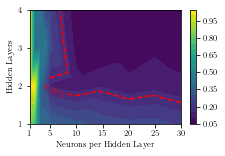

Samples: 100


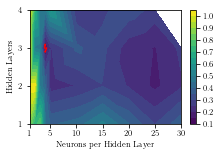

Samples: 10000


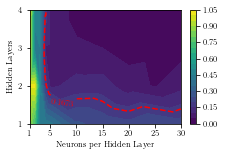

In [9]:
highlight_lvl = 0.16725606071380222

for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[2], levels=20)
    cs2 = ax.tricontour(values[0], values[1], values[2], levels=[highlight_lvl], colors='r')
    cs2.collections[0].set_linestyle('dashed')
    ax.clabel(cs2, cs2.levels, inline=True, fontsize=8)
    fig.colorbar(cs)
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/approximation_error_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


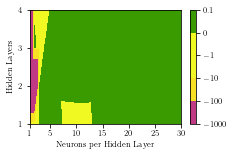

Samples: 100


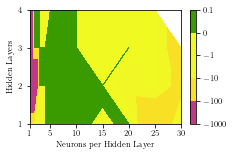

Samples: 10000


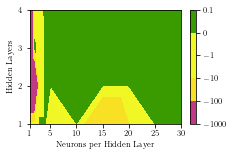

In [6]:
viridis = cm.get_cmap('plasma', 10000)
newcolors = viridis(np.linspace(0, 1, 10000))
green = np.array([57/256, 156/256, 0/256, 1])
newcolors[9999:, :] = green
newcmp = ListedColormap(newcolors)

for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[3], levels=[-1000, -100, -10, -1, -1e-4, 0.1], cmap=newcmp)
    cbar = fig.colorbar(cs)
    cbar.ax.set_yticklabels([r'$-1000$', r'$-100$', r'$-10$', r'$-1$', r'$0$', r'$0.1$'])
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/verify_stability_sufficient_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


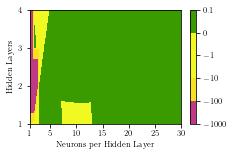

Samples: 100


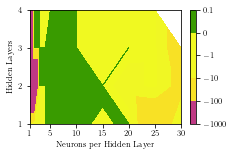

Samples: 10000


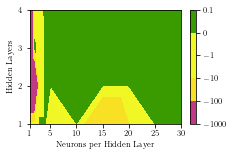

In [7]:
for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[4], levels=[-1000, -100, -10, -1, -1e-4, 0.1], cmap=newcmp)
    cbar = fig.colorbar(cs)
    cbar.ax.set_yticklabels([r'$-1000$', r'$-100$', r'$-10$', r'$-1$', r'$0$', r'$0.1$'])
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/verify_stability_direct_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Samples: 1000


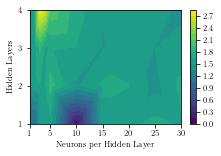

Samples: 100


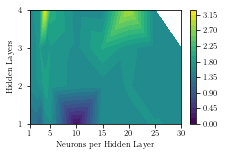

Samples: 10000


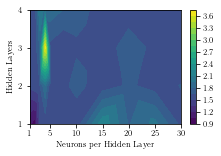

In [8]:
for samples, values in bounds_by_samples.items():
    print(f'Samples: {samples}')
    fig, ax = plt.subplots()
    cs = ax.tricontourf(values[0], values[1], values[5], levels=20)
    fig.colorbar(cs)
    ax.set_xlabel('Neurons per Hidden Layer')
    ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
    ax.set_ylabel('Hidden Layers')
    ax.set_yticks([1, 2, 3, 4])
    plt.savefig(f'figures/approximation_error_lipschitz_constant_{samples}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()